# Eye for Blind – Image Captioning with Attention

# 1. Objective

Eye for Blind: An Assistive Image Captioning System with Visual Attention

This project implements a deep learning model that generates natural language descriptions of images, particularly aimed at visually impaired users. The model leverages an attention mechanism to selectively focus on image regions when generating each word, mimicking human vision.

Inspired by "Show, Attend and Tell" (Xu et al., 2015), this implementation:
1. Uses a CNN encoder (InceptionV3) to extract image features.
2. Applies additive (Bahdanau) attention during decoding.
3. Employs a decoder LSTM to generate captions.
4. Converts generated captions to speech using gTTS.

In [ ]:
import tensorflow_datasets as tfds
import os

# Define paths
DATA_DIR = 'data'
IMAGE_DIR = os.path.join(DATA_DIR, 'flickr30k/images')
CAPTION_FILE = os.path.join(DATA_DIR, 'flickr30k/captions.txt')

# Check if dataset is already downloaded
if not os.path.exists(IMAGE_DIR) or not os.path.exists(CAPTION_FILE):
    print("Flickr30k dataset not found. Downloading...")
    os.makedirs(IMAGE_DIR, exist_ok=True)

    # Download Flickr30k dataset
    dataset, info = tfds.load('flickr30k', split='train', with_info=True, as_supervised=True)

    # Extract images and captions
    captions_dict = {}
    for image, caption in tfds.as_numpy(dataset):
        image_id = info.features['image'].encode_example(image).decode('utf-8').split('/')[-1]
        image_path = os.path.join(IMAGE_DIR, image_id)
        tf.keras.utils.save_img(image_path, image)
        if image_id not in captions_dict:
            captions_dict[image_id] = []
        captions_dict[image_id].append(caption.decode('utf-8'))

    # Save captions to a file
    with open(CAPTION_FILE, 'w') as f:
        f.write('image_id,caption\n')
        for image_id, captions in captions_dict.items():
            for caption in captions:
                f.write(f"{image_id},{caption}\n")

    print(f"Images saved to {IMAGE_DIR}")
    print(f"Captions saved to {CAPTION_FILE}")
else:
    print("Flickr30k dataset is already downloaded.")

# 2. Data Understanding


In [4]:
import os
import json
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from PIL import Image

# Set data path
IMAGE_DIR = 'data/flickr8k/images'              # directory containing images
CAPTION_FILE = 'data/flickr8k/captions.txt'     # preprocessed JSON with image_id: [captions]

# Load caption data from a comma-separated file
def load_captions(path: str) -> dict:
    captions = {}
    with open(path, 'r') as f:
        lines = f.readlines()[1:]  # Skip the header line
        for line in lines:
            image_id, caption = line.strip().split(',', 1)
            if image_id not in captions:
                captions[image_id] = []
            captions[image_id].append(caption)
    return captions

captions_dict = load_captions(CAPTION_FILE)

# Show 3 sample images with 5 ground truth captions each
def display_samples(image_dir: str, captions: dict, num_samples: int = 3):
    sample_keys = random.sample(list(captions.keys()), num_samples)
    for key in sample_keys:
        img_path = os.path.join(image_dir, key)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{key}")
        plt.show()
        for cap in captions[key][:5]:
            print(f"- {cap}")
        print("\n")

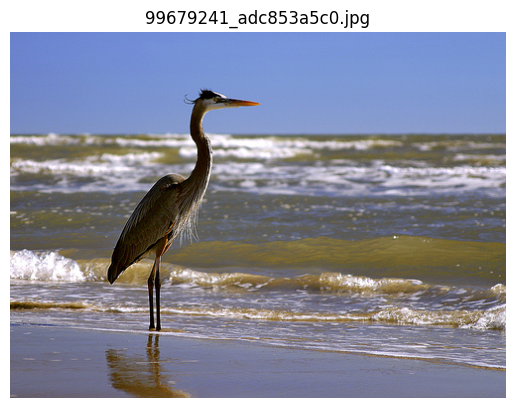

- A grey bird stands majestically on a beach while waves roll in .
- A large bird stands in the water on the beach .
- A tall bird is standing on the sand beside the ocean .
- A water bird standing at the ocean 's edge .
- A white crane stands tall as it looks out upon the ocean .




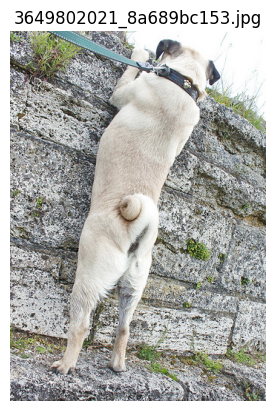

- A Pug dog is standing up on two legs looking over a stone wall .
- A white dog on a green leash is standing on its hind legs to look over a stone wall .
- Dog on a leash looking over a stone wall
- The leashed dog is looking over the stone wall .
- "The white dog is standing on its hind legs , looking over a ledge ."




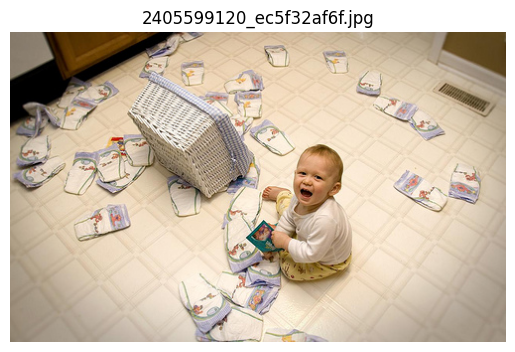

- A baby is sitting on the floor surrounded by diapers and basket .
- A baby on a floor with an overturned basket and articles on the floor .
- A baby plays near an overturned basket of diapers .
- A toddler sits with diapers spread around the floor .
- a young baby sitting in the middle of the floor surrounded by clean diapers




In [5]:
display_samples(IMAGE_DIR, captions_dict)  # Uncomment in Colab


# 3. Data Pre-processing


In [ ]:
import re
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

AUTOTUNE = tf.data.AUTOTUNE
MAX_LEN = 30
BATCH_SIZE = 64
SEED = 42

# NLP utils
def preprocess_caption(caption: str) -> str:
    caption = caption.lower()
    caption = re.sub(r"[^a-z0-9 ]", "", caption)
    return f"<start> {caption.strip()} <end>"

# Build vocabulary with min freq=5
all_captions = [preprocess_caption(c) for caps in captions_dict.values() for c in caps]
word_counts = Counter(word for cap in all_captions for word in cap.split())
filtered_captions = [c for c in all_captions if all(word_counts[w] >= 5 for w in c.split())]

tokenizer = Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(filtered_captions)
vocab_size = len(tokenizer.word_index) + 1

# Prepare sequences
def encode_caption(caption: str):
    seq = tokenizer.texts_to_sequences([caption])[0]
    return pad_sequences([seq], maxlen=MAX_LEN, padding='post')[0], len(seq)

# Vision pipeline
def load_image(image_path: str) -> tf.Tensor:
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize_with_crop_or_pad(img, 224, 224)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

# Prepare dataset list
image_caption_pairs = []
for img, caps in captions_dict.items():
    for c in caps:
        c_proc = preprocess_caption(c)
        if all(word_counts.get(w, 0) >= 5 for w in c_proc.split()):
            image_caption_pairs.append((img, c_proc))

random.seed(SEED)
random.shuffle(image_caption_pairs)
num_total = len(image_caption_pairs)

train_split = int(0.8 * num_total)
val_split = int(0.9 * num_total)
train_data = image_caption_pairs[:train_split]
val_data = image_caption_pairs[train_split:val_split]
test_data = image_caption_pairs[val_split:]

# TF Dataset builder
def data_generator(data: list):
    for img, cap in data:
        img_tensor = load_image(os.path.join(IMAGE_DIR, img))
        token_ids, cap_len = encode_caption(cap)
        yield img_tensor, token_ids, cap_len

output_signature = (
    tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(MAX_LEN,), dtype=tf.int32),
    tf.TensorSpec(shape=(), dtype=tf.int32)
)

def build_tf_dataset(data: list):
    return tf.data.Dataset.from_generator(
        lambda: data_generator(data), output_signature=output_signature
    ).shuffle(1024).padded_batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = build_tf_dataset(train_data)
val_ds = build_tf_dataset(val_data)

# 4. Model Building


In [ ]:
from tensorflow.keras import layers, Model

class Encoder(Model):
    def __init__(self):
        super().__init__()
        base = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
        base.trainable = False
        self.cnn = Model(base.input, base.get_layer('mixed10').output)
        self.reshape = layers.Reshape((64, 2048))

    def call(self, x):
        x = self.cnn(x)
        return self.reshape(x)  # (batch, 64, 2048)

class BahdanauAttention(layers.Layer):
    def __init__(self, units: int):
        super().__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)

    def call(self, features, hidden):
        hidden_exp = tf.expand_dims(hidden, 1)
        score = self.V(tf.nn.tanh(self.W1(features) + self.W2(hidden_exp)))
        alpha = tf.nn.softmax(score, axis=1)
        context = tf.reduce_sum(alpha * features, axis=1)
        return context, tf.squeeze(alpha, -1)  # (batch, 2048), (batch, 64)

class Decoder(Model):
    def __init__(self, embedding_dim: int, units: int, vocab_size: int):
        super().__init__()
        self.units = units
        self.embed = layers.Embedding(vocab_size, embedding_dim)
        self.lstm = layers.LSTM(units, return_sequences=True, return_state=True)
        self.fc = layers.Dense(vocab_size)
        self.att = BahdanauAttention(units)
        self.tie_proj = layers.Dense(embedding_dim)

    def call(self, x, features, hidden, cell):
        context, alpha = self.att(features, hidden)
        x = self.embed(x)
        x = tf.concat([tf.expand_dims(context, 1), x], axis=-1)
        output, h, c = self.lstm(x, initial_state=[hidden, cell])
        logits = self.fc(output)
        return logits, h, c, alpha

# 5. Training

from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from nltk.translate.bleu_score import corpus_bleu

encoder = Encoder()
decoder = Decoder(embedding_dim=512, units=512, vocab_size=vocab_size)

optimizer = tf.keras.optimizers.Adam(learning_rate=CosineDecay(1e-3, decay_steps=10000))
loss_fn = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

@tf.function
def train_step(img_tensor, target, cap_len):
    loss = 0.0
    hidden = tf.zeros((img_tensor.shape[0], 512))
    cell = tf.zeros_like(hidden)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * img_tensor.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for t in range(1, MAX_LEN):
            logits, hidden, cell, _ = decoder(dec_input, features, hidden, cell)
            loss_ = loss_fn(target[:, t], tf.squeeze(logits, 1))
            mask = tf.cast(target[:, t] > 0, tf.float32)
            loss += tf.reduce_sum(loss_ * mask)
            dec_input = tf.expand_dims(target[:, t], 1)

    variables = encoder.trainable_variables + decoder.trainable_variables
    grads = tape.gradient(loss, variables)
    grads, _ = tf.clip_by_global_norm(grads, 5.0)
    optimizer.apply_gradients(zip(grads, variables))
    return loss / tf.reduce_sum(tf.cast(cap_len, tf.float32))

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0.0
    for img, tgt, cap_len in train_ds:
        total_loss += train_step(img, tgt, cap_len)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")  # TODO: Add BLEU-4 validation score here